In [1]:
from keras.utils import HDF5Matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.utils import to_categorical
import tensorflow.compat.v1 as tf
import keras
from keras.layers import Input, Dense, BatchNormalization, Dropout, Conv2D, MaxPool2D, Flatten, LeakyReLU
import numpy as np
import pandas as pd
import imageio
from IPython.display import Image

import src.models as my_model
import src.pcam_loader as data

Using TensorFlow backend.


In [2]:
# Show if tensorflow can run with GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15683101057746166277
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4854028697
locality {
  bus_id: 1
  links {
  }
}
incarnation: 42948794015214926
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5"
]


In [3]:
## Run tensorflow keras on multiple core
# config = tf.ConfigProto(device_count={"CPU": 8})
# tensorflow.compat.v1.keras.backend.set_session(tf.Session(config=config))
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5



## Load pcam data

In [4]:
# Load data from /User/Username/.keras/datasets/pcam
dataset = data.load_data()
x_train, y_train, meta_train =  dataset[0]
x_valid, y_valid, meta_valid =  dataset[1]
x_test, y_test, meta_test =  dataset[2]

In [5]:
y_train = np.array(y_train[:])
y_train = y_train.reshape(-1, 1)
y_valid = np.array(y_valid[:])
y_valid = y_valid.reshape(-1, 1)
y_test = np.array(y_test[:])
y_test = y_test.reshape(-1, 1)

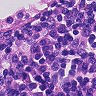

In [6]:
# Save data into png format and visualize image
# imageio.imwrite('image.png', )
Image(filename='./data/image.png') 

In [7]:
print(meta_train.head(5), '\n')
print(meta_train.info())

# Shape of train, valid and test input are the same, don't need to preprocess
print('\n' + 'Shape of train', x_train.shape,  len(y_train), y_train.shape)
print('Shape of valid', x_valid.shape,  len(y_valid), y_valid.shape)
print('Shape of test', x_test.shape, len(y_test), y_test.shape)


   Unnamed: 0  coord_y  coord_x  tumor_patch  center_tumor_patch  \
0           0    63104    43648        False               False   
1           1   148544    74048         True                True   
2           2    64192    78912         True                True   
3           3    98048    72128         True                True   
4           4    27264    50688        False               False   

                           wsi  
0   camelyon16_train_tumor_104  
1   camelyon16_train_tumor_003  
2   camelyon16_train_tumor_089  
3   camelyon16_train_tumor_004  
4  camelyon16_train_normal_118   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262144 entries, 0 to 262143
Data columns (total 6 columns):
Unnamed: 0            262144 non-null int64
coord_y               262144 non-null int64
coord_x               262144 non-null int64
tumor_patch           262144 non-null bool
center_tumor_patch    262144 non-null bool
wsi                   262144 non-null object
dtypes: bool(2), i

## Build model

In [8]:
batch_size = 64
epochs = 10
num_classes = 2
shape = (96, 96, 3)

In [9]:
# Model with 3CNN droupout accurancy 74,9%
# Model without droupout and 3CNN accurancy 72,29%
# Model with droupout and 5 CNNN accurany 63%
# Simple CNN with 4 Convolutional layers and 2 Full connected layers, dropout

input_layer = Input(shape=shape)

conv1 = Conv2D(32, (3, 3), padding='same', activation='linear')(input_layer)
conv1 = LeakyReLU(alpha=0.1)(conv1)
conv1 = MaxPool2D((2, 2))(conv1)
conv1 = Dropout(0.25)(conv1)

conv2 = Conv2D(64, (3, 3), padding='same', activation='linear')(conv1)
conv2 = LeakyReLU(alpha=0.1)(conv2)
conv2 = MaxPool2D((2, 2))(conv2)
conv2 = Dropout(0.25)(conv2)

conv3 = Conv2D(128, (3, 3), padding='same', activation='linear')(conv2)
conv3 = LeakyReLU(alpha=0.1)(conv3)
conv3 = MaxPool2D((2, 2))(conv3)
conv3 = Dropout(0.25)(conv3)

conv4 = Conv2D(256, (3, 3), padding='same', activation='linear')(conv3)
conv4 = LeakyReLU(alpha=0.1)(conv4)
conv4 = MaxPool2D((2, 2))(conv4)
conv4 = Dropout(0.25)(conv4)

conv5 = Conv2D(512, (3, 3), padding='same', activation='linear')(conv4)
conv5 = LeakyReLU(alpha=0.1)(conv5)
conv5 = MaxPool2D((2, 2))(conv5)
conv5 = Dropout(0.25)(conv5)

dense1 = Flatten()(conv4)
dense1 = Dense(128, activation='linear')(dense1)
dense1 = LeakyReLU(alpha=0.1)(dense1)

output = Dense(num_classes, activation='softmax')(dense1)

# model = Model(input=[input_layer], output=[output])


C:\Users\matho\MyDatas\Bachelor\src\models.py:89: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  model = Model(input=[input_layer], output=[output])


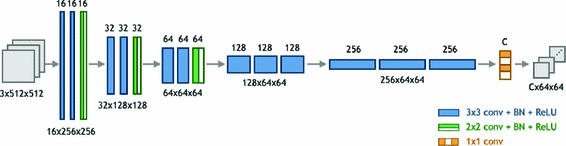

In [10]:
# Model CNN1 accurancy 73% on test on valid 90%
model = my_model.cnn1(shape, num_classes)
Image(filename='./data/cnn1.png')

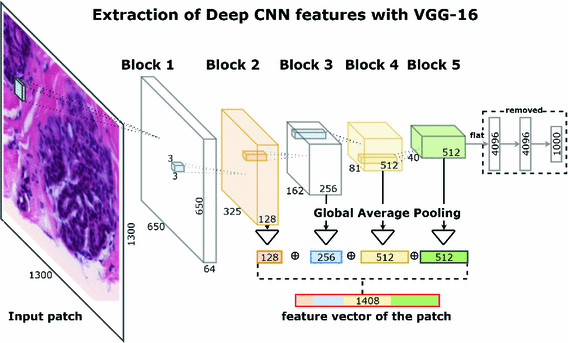

In [11]:
# Model CNN2
# model = my_model.cnn2(shape, num_classes)
Image(filename='./data/cnn2.PNG')

### Compile and train the model

In [12]:
# Try multiple_GPU in keras
# from keras.utils.training_utils import multi_gpu_model
# model = multi_gpu_model(model, gpus=G)

model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 96, 3)         13840     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 96, 3)         64        
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 96, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 96, 3)         2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 96, 3)         64        
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 96, 3)         0   

In [13]:
model.fit(
    x_train,
    to_categorical(y_train),
    # batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_valid, to_categorical(y_valid)),
    shuffle='batch',
    # Add multiprocessing and workers
    use_multiprocessing=True, 
    workers=8
)

Train on 262144 samples, validate on 32768 samples
Epoch 1/10
262144/262144 [==============================] - 389s 1ms/step - loss: 1.0512 - accuracy: 0.7300 - val_loss: 1.7659 - val_accuracy: 0.4792
Epoch 2/10
262144/262144 [==============================] - 384s 1ms/step - loss: 0.4444 - accuracy: 0.8587 - val_loss: 0.6158 - val_accuracy: 0.6861
Epoch 3/10
262144/262144 [==============================] - 381s 1ms/step - loss: 0.3136 - accuracy: 0.8779 - val_loss: 0.5879 - val_accuracy: 0.7257
Epoch 4/10
262144/262144 [==============================] - 384s 1ms/step - loss: 0.2769 - accuracy: 0.8889 - val_loss: 0.4926 - val_accuracy: 0.7640
Epoch 5/10
262144/262144 [==============================] - 385s 1ms/step - loss: 0.2602 - accuracy: 0.8950 - val_loss: 0.5364 - val_accuracy: 0.7435
Epoch 6/10
262144/262144 [==============================] - 380s 1ms/step - loss: 0.2531 - accuracy: 0.8974 - val_loss: 0.5254 - val_accuracy: 0.7362
Epoch 7/10
262144/262144 [=======================

In [14]:
model.save("model_cnn1_with_dropout.h5")

In [15]:
test_eval = model.evaluate(x_test, to_categorical(y_test), verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


Test loss: 0.7898918011997011
Test accuracy: 0.664581298828125
